# Pokersters Fantasy Football Notebook
Lets do the data thang

In [103]:
# !pip install sleeper-api-wrapper
# !pip install matplotlib-label-lines

### Initialize

In [77]:
from sleeper_wrapper import League, Stats, Players
import pandas as pd
import numpy as np
import io
import csv
import re
import pickle
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
from labellines import labelLine, labelLines

league_id = 723630813350014976
league = League(league_id)
players = Players()
# players_df = pd.read_pickle('./sleeper_players.pkl')
# ffa_proj_df = pd.read_pickle("./ffa_proj.pkl")

In [78]:
# import player projection data from spreadsheet
with open('sleeper_players.pkl', 'wb') as file:
    ffa_proj_df = pd.read_csv('ffa_all_week3_09-23-2021.txt', sep='\t', index_col=False)
    ffa_proj_df['Player'] = ffa_proj_df['Player'].str.replace('.', '')
    ffa_proj_df['Player_Pos'] = ffa_proj_df['Player'] + ffa_proj_df['Position']
    # why is the abbr for vegas LVR rather than LV??? annoying
    ffa_proj_df['Team'].replace({'LVR': 'LV', 'JAC': 'JAX'}, inplace=True)
    # convert defense player names from common name to abbreviated to match sleeper
    ffa_proj_df.to_pickle('./ffa_proj.pkl')

ffa_proj_df.head()

<ipython-input-78-db7d2a2a4a15>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  ffa_proj_df['Player'] = ffa_proj_df['Player'].str.replace('.', '')


,Player,Team,Position,Floor,Mean,Ceiling,SD,Risk,VOR,Drop Off,Tier,ADP,Player_Pos
0,Lamar Jackson,BAL,QB,23.2,26.0,28.9,2.05,4.84,0.477,1.0,NaN,NaN,Lamar JacksonQB
1,Kyler Murray,ARI,QB,22.5,25.5,27.6,2.04,4.27,0.293,1.0,NaN,NaN,Kyler MurrayQB
2,Patrick Mahomes,KC,QB,22.8,25.2,27.1,1.82,4.45,1.700,2.0,NaN,NaN,Patrick MahomesQB
3,Jalen Hurts,PHI,QB,19.6,23.5,28.9,3.67,7.13,1.040,3.0,NaN,NaN,Jalen HurtsQB
4,Christian McCaffrey,CAR,RB,20.7,22.7,25.6,1.73,4.03,3.350,1.0,NaN,NaN,Christian McCaffreyRB


In [79]:
# Import players from sleeper, run this block to get updated players data
players_dict = players.get_all_players()
players_df = pd.DataFrame(players_dict).transpose()
players_df['full_name'] = players_df['full_name'].str.replace('.', '')
players_df['full_name_pos'] = players_df['full_name'] + players_df['position']
players_df = players_df.reset_index()
players_df = players_df.merge(ffa_proj_df, left_on='full_name_pos', right_on='Player_Pos', how='left')
players_df['player_id'] = players_df['index'].fillna(players_df['Team'])
players_df = players_df.set_index('player_id')
players_df = players_df.drop(columns=['index'])
for i in players_df.loc[players_df['fantasy_positions'].apply(lambda x: True if x and 'DEF' in x else False).tolist()].index.tolist():
    players_df.loc[i, ffa_proj_df.columns] = ffa_proj_df[(ffa_proj_df['Position'] == 'DST') & (ffa_proj_df['Team'] == i)].iloc[0]
players_df[ffa_proj_df.columns] = players_df[ffa_proj_df.columns].fillna(0)
players_df.to_pickle('./sleeper_players.pkl')
players_df.head()

<ipython-input-79-28cdabd0e2e3>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  players_df['full_name'] = players_df['full_name'].str.replace('.', '')


,espn_id,last_name,fantasy_positions,birth_state,gsis_id,metadata,birth_city,birth_country,stats_id,height,...,Floor,Mean,Ceiling,SD,Risk,VOR,Drop Off,Tier,ADP,Player_Pos
player_id,,,,,,,,,,,,,,,,,,,,,
2103,17054,Booth,[OL],None,None,None,None,None,None,"6'5""",...,0.0,0.0,0.0,0.00,0.00,0.000,0.0,0.0,0.0,0
6250,3916426,Bryant,[DL],None,None,None,None,None,None,,...,0.0,0.0,0.0,0.00,0.00,0.000,0.0,0.0,0.0,0
4116,2972820,Garcia,[OL],None,00-0033922,None,None,None,None,"6'6""",...,0.0,0.0,0.0,0.00,0.00,0.000,0.0,0.0,0.0,0
6177,3121634,Saunders,[DL],None,00-0035656,None,None,None,None,"6'0""",...,0.0,0.0,0.0,0.00,0.00,0.000,0.0,0.0,0.0,0
5870,3917792,Jones,[QB],None,00-0035710,None,None,None,879981,"6'5""",...,17.9,20.2,21.4,1.31,6.99,0.859,5.0,0.0,0.0,Daniel JonesQB


In [80]:
ffa_proj_df.head()

,Player,Team,Position,Floor,Mean,Ceiling,SD,Risk,VOR,Drop Off,Tier,ADP,Player_Pos
0,Lamar Jackson,BAL,QB,23.2,26.0,28.9,2.05,4.84,0.477,1.0,NaN,NaN,Lamar JacksonQB
1,Kyler Murray,ARI,QB,22.5,25.5,27.6,2.04,4.27,0.293,1.0,NaN,NaN,Kyler MurrayQB
2,Patrick Mahomes,KC,QB,22.8,25.2,27.1,1.82,4.45,1.700,2.0,NaN,NaN,Patrick MahomesQB
3,Jalen Hurts,PHI,QB,19.6,23.5,28.9,3.67,7.13,1.040,3.0,NaN,NaN,Jalen HurtsQB
4,Christian McCaffrey,CAR,RB,20.7,22.7,25.6,1.73,4.03,3.350,1.0,NaN,NaN,Christian McCaffreyRB


### Get Leaguemates data

In [81]:
users = league.get_users()
users_df = pd.DataFrame(users)
users_df = users_df.set_index(users_df.columns[0])
users_df

,settings,metadata,league_id,is_owner,is_bot,display_name,avatar
user_id,,,,,,,
375038190341611520,None,"{'team_name': 'The Trolley Problems', 'mention...",723630813350014976,None,False,thinkfast86,3c7def417a4613d104ae66403af0e0e7
607043401484926976,None,"{'team_name': 'Rebuilding year', 'show_mascots...",723630813350014976,None,False,mmasison,e36c64e702e2db846c91eb439a13df6a
608864437348163584,None,"{'team_name': 'Je Ne Saquon', 'mention_pn': 'o...",723630813350014976,None,False,TheVermanator,None
723630209273765888,None,"{'team_name': 'Hit Quads like Saquon', 'mentio...",723630813350014976,True,False,benslayer68,None
723633476015857664,None,"{'team_name': 'Tom Brady's Son', 'mention_pn':...",723630813350014976,None,False,dlaffs,6e0dc0a80e7d0560d8ef4777d3a90b16
723650381690769408,None,"{'team_name': '10,000 Rats', 'show_mascots': '...",723630813350014976,None,False,mikulis,ea2334c4e55f4c7d1d1544544eae3f54
723683736822059008,None,"{'mascot_item_type_id_leg_6': 'ref', 'mascot_i...",723630813350014976,None,False,schlaich,0008e9a0c13d1ebb16549afa8e884ef3
723753245457104896,None,"{'mention_pn': 'on', 'mascot_message_emotion_l...",723630813350014976,None,False,izzyfoshizzy8,15d7cf259bc30eab8f6120f45f652fb6
723755503108349952,None,"{'team_name': 'Mahomes’ Modern Life', 'mention...",723630813350014976,None,False,hunterm19,6c08fd9d771cdc622d9c57632a02aa6d


In [82]:
rosters = league.get_rosters()
rosters_df = pd.DataFrame(rosters)
# if someone doesn't have a team name, use username
rosters_df['team_name'] = rosters_df['owner_id'].apply(lambda x: users_df.loc[x]['metadata']['team_name'] if 'team_name' in users_df.loc[x]['metadata'] else users_df.loc[x]['display_name'])
rosters_df.head()

,taxi,starters,settings,roster_id,reserve,players,player_map,owner_id,metadata,league_id,co_owners,team_name
0,None,"[4881, 6151, 4663, 4068, 6786, 1466, 5045, 126...","{'wins': 4, 'waiver_position': 5, 'waiver_budg...",1,None,"[1266, 1466, 3200, 3423, 4068, 4663, 4881, 500...",None,723630209273765888,"{'streak': '4W', 'record': 'WWWW'}",723630813350014976,None,Hit Quads like Saquon
1,None,"[421, 4029, 5892, 6801, 4039, 4217, 4319, 391,...","{'wins': 3, 'waiver_position': 8, 'waiver_budg...",2,[5284],"[1535, 3664, 391, 4029, 4039, 421, 4217, 4319,...",None,375038190341611520,"{'streak': '1L', 'record': 'WWWL'}",723630813350014976,None,The Trolley Problems
2,None,"[167, 5980, 5850, 7601, 4131, 515, 6789, 4227,...","{'wins': 3, 'waiver_position': 7, 'waiver_budg...",3,[3199],"[167, 1825, 2306, 2325, 3199, 4131, 4227, 515,...",None,607043401484926976,"{'streak': '1W', 'record': 'WWLW'}",723630813350014976,None,Rebuilding year
3,None,"[1049, 4035, 4273, 4981, 4983, 5012, 5846, 274...","{'wins': 1, 'waiver_position': 12, 'waiver_bud...",4,None,"[1049, 1144, 24, 2747, 4035, 4273, 4962, 4981,...",None,723633476015857664,"{'streak': '1L', 'record': 'LLWL'}",723630813350014976,None,Tom Brady's Son
4,None,"[6797, 4866, 4018, 1352, 5927, 4602, 1067, 650...","{'wins': 0, 'waiver_position': 9, 'waiver_budg...",5,[5038],"[1067, 1352, 2028, 2168, 3225, 4018, 4602, 486...",None,608864437348163584,"{'streak': '4L', 'record': 'LLLL'}",723630813350014976,None,Je Ne Saquon


In [83]:
for col in ['Floor','Mean','Ceiling','Risk','VOR']:
    rosters_df['Starters_' + col] = rosters_df['starters'].apply(lambda s: sum(players_df.loc[[i for i in s if i != '0']][col]))

rosters_df['Starters_Variance'] = rosters_df['starters'].apply(lambda s: sum(players_df.loc[[i for i in s if i != '0']]['SD']**2))
rosters_df['Starters_SD'] = rosters_df['Starters_Variance']**(1/2)
rosters_df

,taxi,starters,settings,roster_id,reserve,players,player_map,owner_id,metadata,league_id,co_owners,team_name,Starters_Floor,Starters_Mean,Starters_Ceiling,Starters_Risk,Starters_VOR,Starters_Variance,Starters_SD
0,None,"[4881, 6151, 4663, 4068, 6786, 1466, 5045, 126...","{'wins': 4, 'waiver_position': 5, 'waiver_budg...",1,None,"[1266, 1466, 3200, 3423, 4068, 4663, 4881, 500...",None,723630209273765888,"{'streak': '4W', 'record': 'WWWW'}",723630813350014976,None,Hit Quads like Saquon,107.34,122.79,144.67,39.36,3.395900,33.132234,5.756061
1,None,"[421, 4029, 5892, 6801, 4039, 4217, 4319, 391,...","{'wins': 3, 'waiver_position': 8, 'waiver_budg...",2,[5284],"[1535, 3664, 391, 4029, 4039, 421, 4217, 4319,...",None,375038190341611520,"{'streak': '1L', 'record': 'WWWL'}",723630813350014976,None,The Trolley Problems,96.19,110.13,126.66,35.33,1.617800,22.252554,4.717261
2,None,"[167, 5980, 5850, 7601, 4131, 515, 6789, 4227,...","{'wins': 3, 'waiver_position': 7, 'waiver_budg...",3,[3199],"[167, 1825, 2306, 2325, 3199, 4131, 4227, 515,...",None,607043401484926976,"{'streak': '1W', 'record': 'WWLW'}",723630813350014976,None,Rebuilding year,71.84,90.95,111.84,51.54,1.904800,43.977800,6.631576
3,None,"[1049, 4035, 4273, 4981, 4983, 5012, 5846, 274...","{'wins': 1, 'waiver_position': 12, 'waiver_bud...",4,None,"[1049, 1144, 24, 2747, 4035, 4273, 4962, 4981,...",None,723633476015857664,"{'streak': '1L', 'record': 'LLWL'}",723630813350014976,None,Tom Brady's Son,102.50,115.74,131.64,36.58,2.494900,19.924784,4.463719
4,None,"[6797, 4866, 4018, 1352, 5927, 4602, 1067, 650...","{'wins': 0, 'waiver_position': 9, 'waiver_budg...",5,[5038],"[1067, 1352, 2028, 2168, 3225, 4018, 4602, 486...",None,608864437348163584,"{'streak': '4L', 'record': 'LLLL'}",723630813350014976,None,Je Ne Saquon,91.28,103.52,118.57,34.87,1.365720,18.465621,4.297164
5,None,"[4984, 4034, 4988, 5859, 1689, 2505, 5916, 704...","{'wins': 3, 'waiver_position': 2, 'waiver_budg...",6,[6806],"[1689, 2078, 2505, 3969, 4034, 4137, 4984, 498...",None,723650381690769408,"{'streak': '3W', 'record': 'LWWW', 'p_nick_TB'...",723630813350014976,None,"10,000 Rats",104.98,121.96,140.95,39.69,8.104400,26.890425,5.185598
6,None,"[3294, 6955, 2320, 2449, 2133, 2251, 2309, 143...","{'wins': 1, 'waiver_position': 1, 'waiver_budg...",7,[7543],"[1433, 1848, 2133, 2197, 2251, 2309, 2319, 232...",None,723683736822059008,"{'streak': '2L', 'restrict_pn_scoring_starters...",723630813350014976,None,The Zany Zebras,82.06,104.92,123.69,47.03,3.334000,48.508844,6.964829
7,None,"[96, 4199, 2431, 947, 1426, 4089, 5872, 49, LAR]","{'wins': 2, 'waiver_position': 4, 'waiver_budg...",8,[5248],"[1166, 1426, 1476, 2431, 4089, 4199, 49, 5248,...",None,723753245457104896,"{'streak': '2W', 'record': 'LLWW'}",723630813350014976,None,izzyfoshizzy8,85.77,101.70,119.15,40.17,2.415389,25.161500,5.016124
8,None,"[4046, 6790, 3242, 3321, 4037, 5857, 6886, 126...","{'wins': 2, 'waiver_position': 3, 'waiver_budg...",9,None,"[1264, 3157, 3214, 3242, 3321, 4037, 4046, 435...",None,723755503108349952,"{'streak': '2L', 'record': 'WWLL'}",723630813350014976,None,Mahomes’ Modern Life,93.00,107.28,123.17,35.51,3.113100,20.400302,4.516669
9,None,"[6904, 3164, 6945, 1479, 2374, 7553, 6820, 509...","{'wins': 2, 'waiver_position': 11, 'waiver_bud...",10,[4082],"[1479, 2374, 3164, 367, 4082, 4149, 5095, 5937...",None,724012989333708800,"{'streak': '1W', 'record': 'WLLW'}",723630813350014976,None,Belichick Yo Self,95.08,111.63,135.65,40.59,3.639600,41.012800,6.404124


In [84]:
plt.rcParams['figure.figsize'] = [30, 15]

<AxesSubplot:xlabel='team_name'>

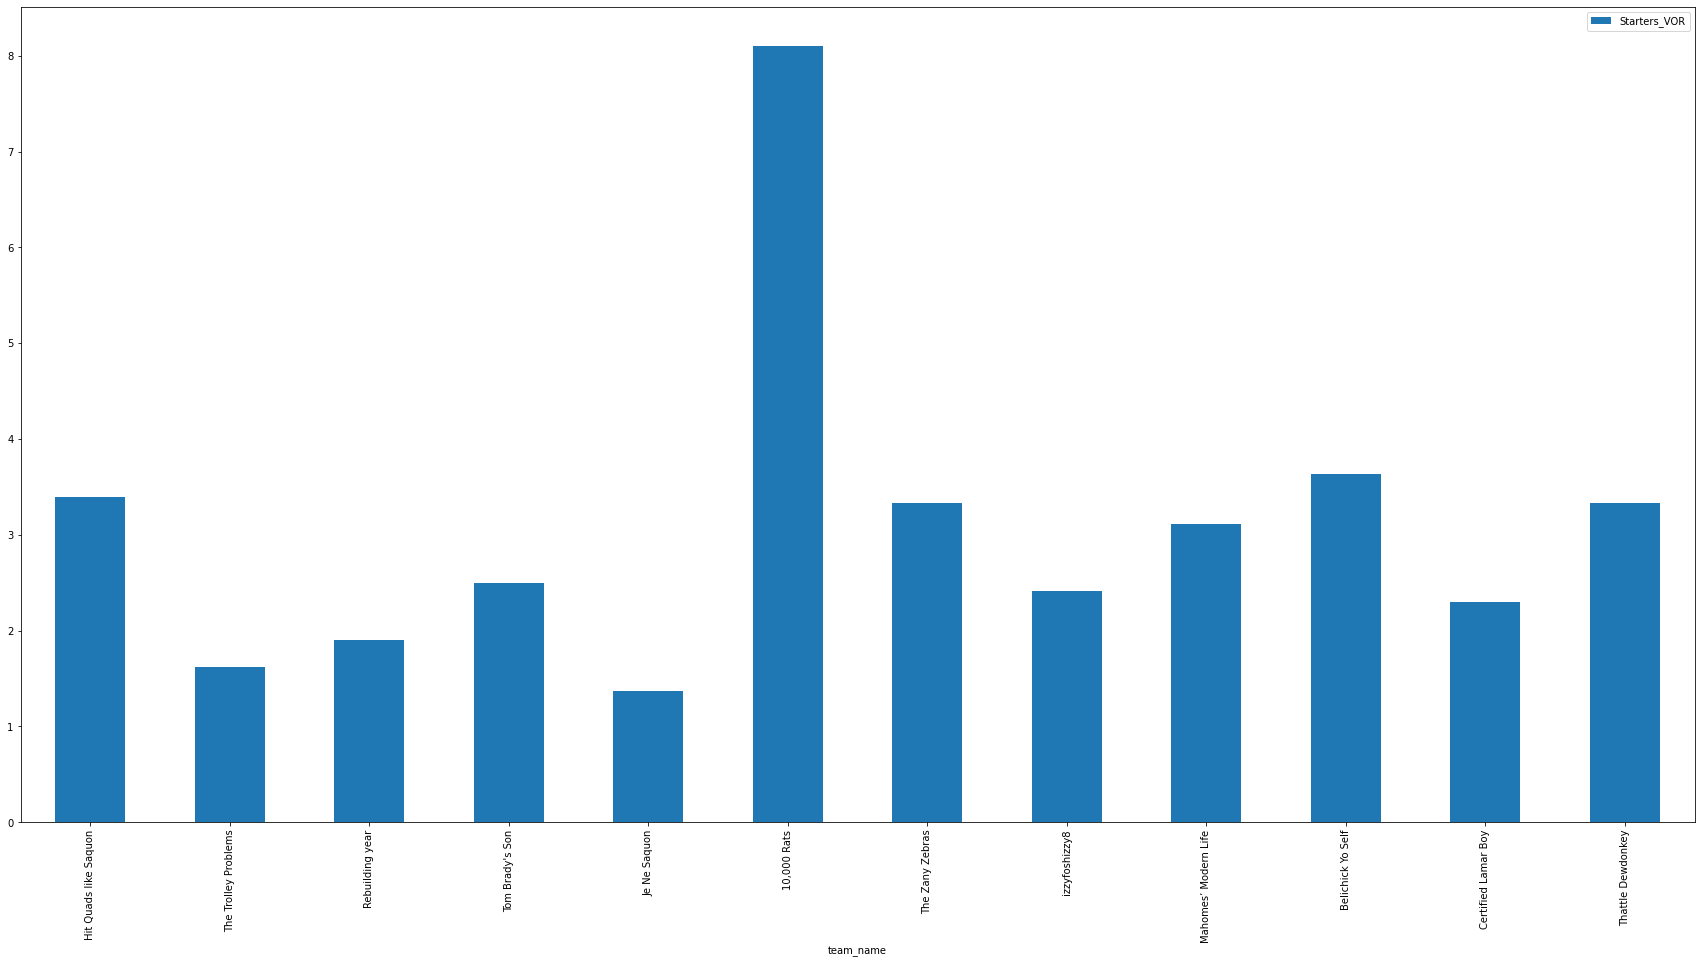

In [101]:
rosters_df.plot.bar(x='team_name', y='Starters_VOR')

In [86]:
players_df.loc[[x for x in rosters_df.iloc[11]['starters'] if x != '0']].loc[:, ['full_name', 'Mean']]

,full_name,Mean
player_id,,
5849,Kyler Murray,25.50
3198,Derrick Henry,18.80
7098,Ty'Son Williams,11.90
6794,Justin Jefferson,15.20
4036,Corey Davis,10.80
3271,Tyler Higbee,8.70
7561,Elijah Mitchell,0.00
17,Matt Prater,0.00
PIT,NaN,8.28


<AxesSubplot:xlabel='team_name'>

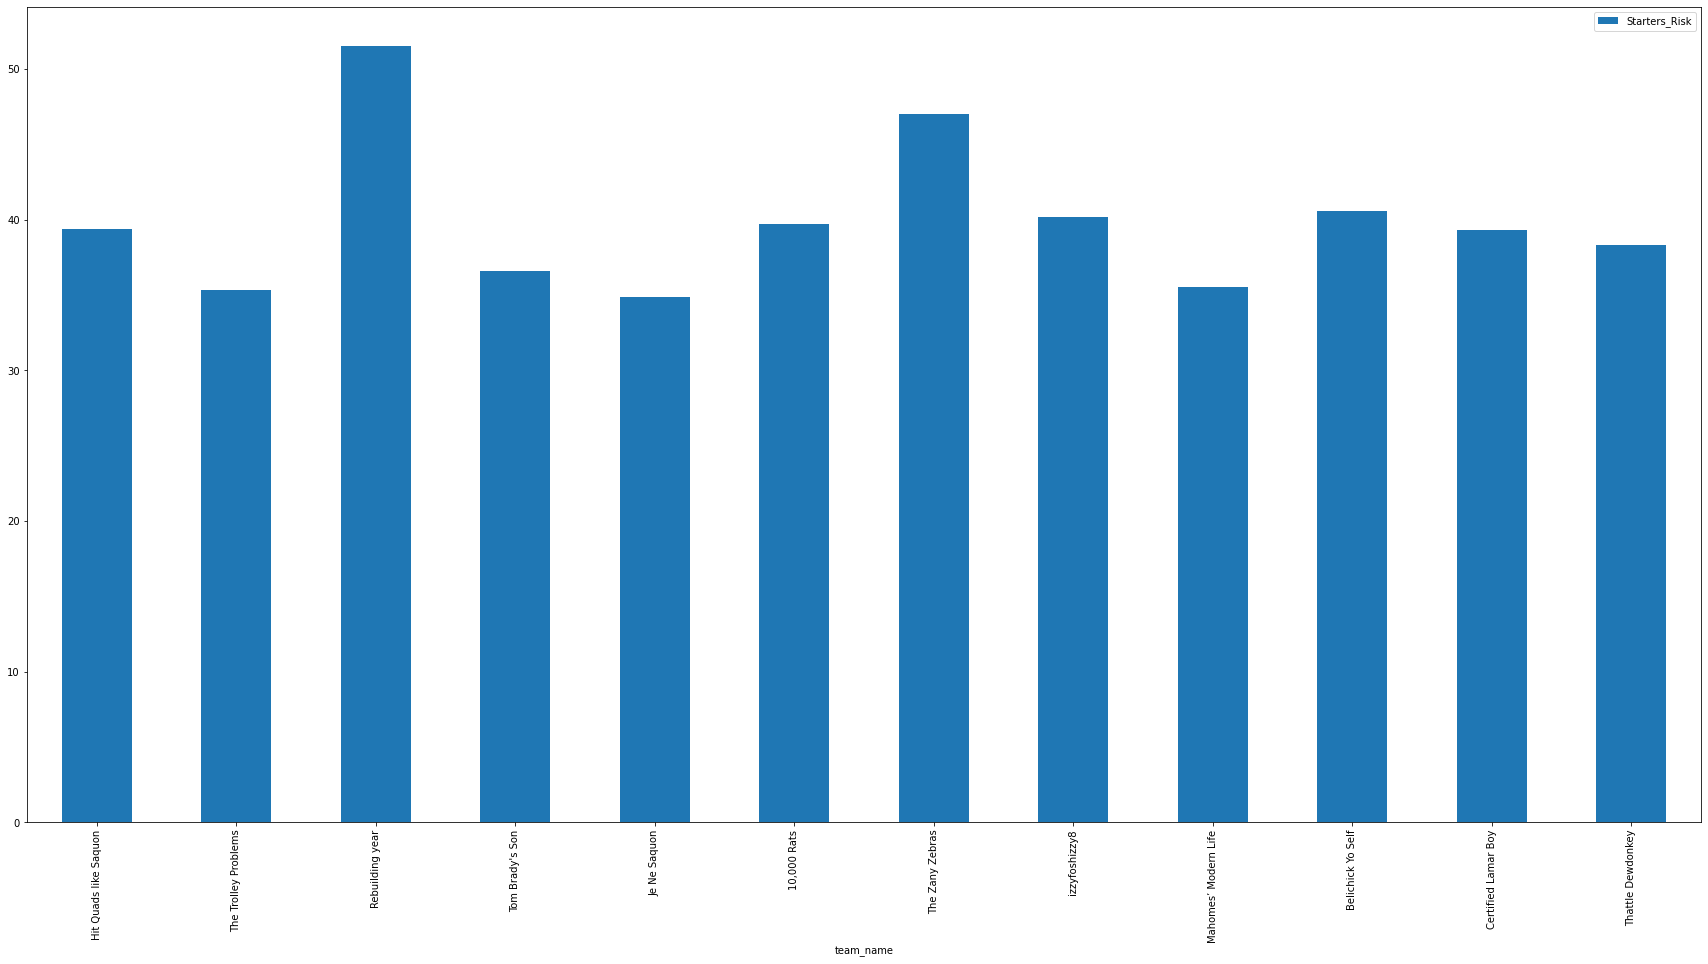

In [87]:
rosters_df.plot.bar(x='team_name', y='Starters_Risk')

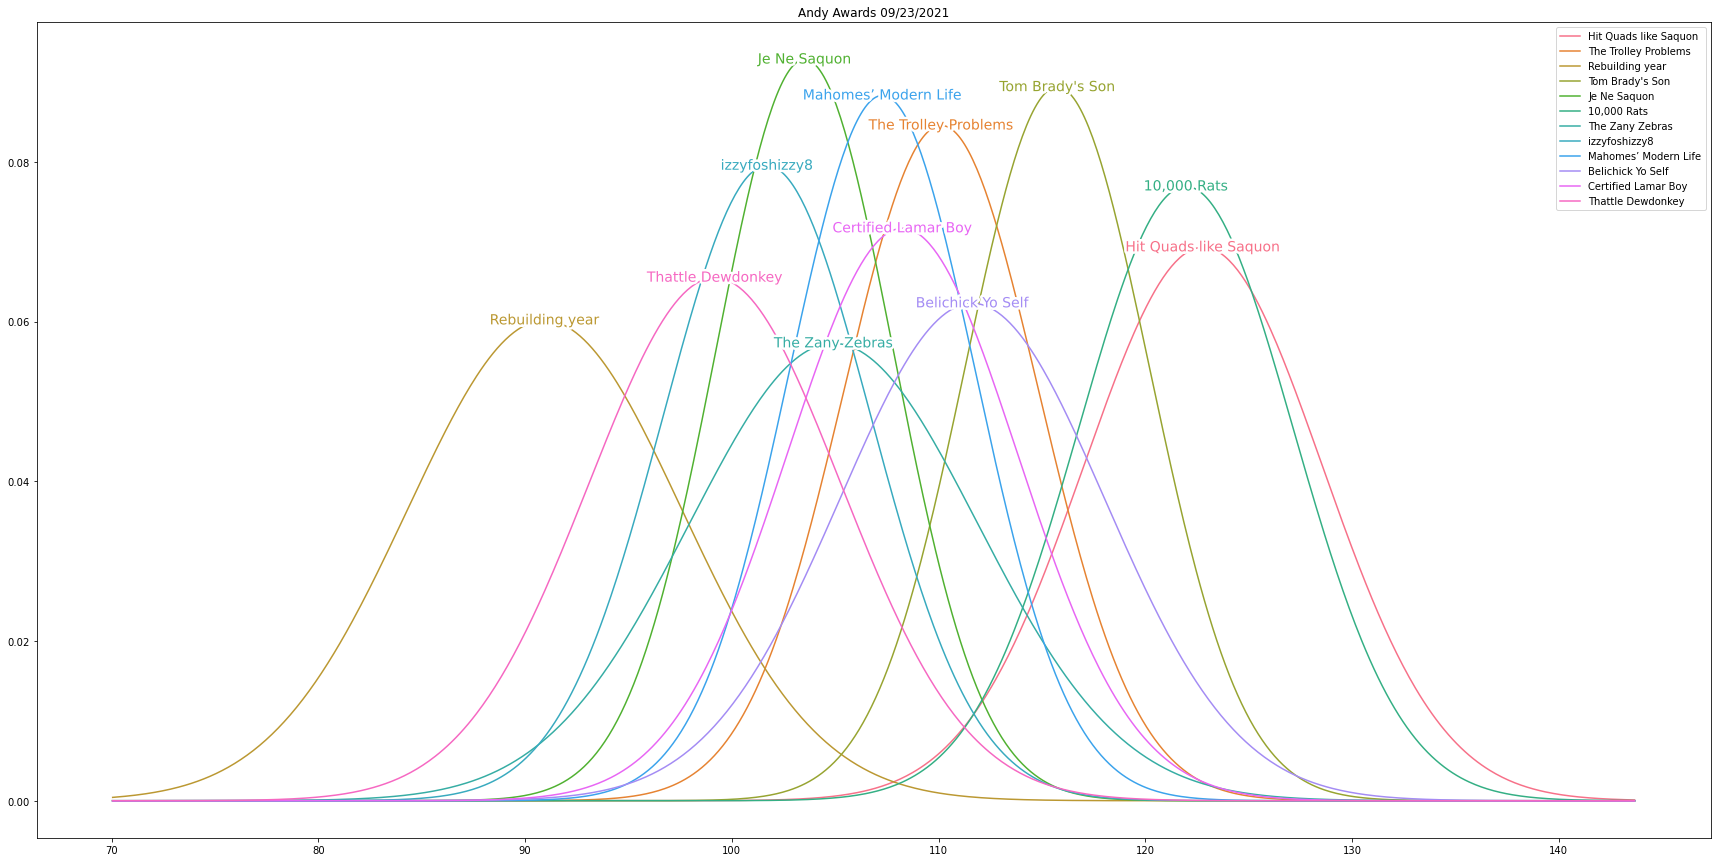

In [99]:
plt.rcParams['figure.figsize'] = [30, 15]
fig, ax1 = plt.subplots()
colors = sns.color_palette("husl", rosters_df.shape[0])
ax1.set_prop_cycle('color', colors)
x_axis = np.arange(rosters_df['Starters_Mean'].min() - 3*rosters_df['Starters_SD'].max(), rosters_df['Starters_Mean'].max() + 3*rosters_df['Starters_SD'].max(), .1)

for roster in rosters_df.iterrows():  
    plt.plot(x_axis, norm.pdf(x_axis, roster[1]['Starters_Mean'], roster[1]['Starters_SD']), label=roster[1]['team_name'])
    
labelLines(plt.gca().get_lines(), fontsize=14, align=True,  xvals = rosters_df['Starters_Mean'], zorder=2.5)
plt.legend()

ax1.title.set_text('Andy Awards 09/23/2021')
plt.show()

In [89]:
rosters_df.loc[:, ['team_name', 'Starters_Mean', 'Starters_SD']].sort_values(by='Starters_Mean')

,team_name,Starters_Mean,Starters_SD
2,Rebuilding year,90.95,6.631576
11,Thattle Dewdonkey,99.18,6.090156
7,izzyfoshizzy8,101.70,5.016124
4,Je Ne Saquon,103.52,4.297164
6,The Zany Zebras,104.92,6.964829
8,Mahomes’ Modern Life,107.28,4.516669
10,Certified Lamar Boy,108.25,5.564953
1,The Trolley Problems,110.13,4.717261
9,Belichick Yo Self,111.63,6.404124
3,Tom Brady's Son,115.74,4.463719


In [76]:
rosters_df.loc[:, ['team_name', 'Starters_Ceiling', 'Starters_Floor']].sort_values(by='Starters_Floor')

,team_name,Starters_Ceiling,Starters_Floor
2,Rebuilding year,111.84,71.84
6,The Zany Zebras,123.69,82.06
11,Thattle Dewdonkey,119.10,82.91
7,izzyfoshizzy8,119.15,85.77
4,Je Ne Saquon,118.57,91.28
10,Certified Lamar Boy,128.21,92.73
8,Mahomes’ Modern Life,123.17,93.00
9,Belichick Yo Self,135.65,95.08
1,The Trolley Problems,126.66,96.19
3,Tom Brady's Son,131.64,102.50


In [ ]:
matchups = league.get_matchups(2)

In [ ]:
matchups[0]

### Import SI fantasy projections 2021

#### Sanitize SI Fantasy Football Rankings 2021

I didn't actually end up using this, the data was too gross

In [ ]:
with open('2021 SI Fantasy Football Rankings & Projections - Rosters.csv', newline='') as readfile:
    with open('SI_Projections_2021_Sanitizied.csv', 'w', newline='') as writefile:
        reader = csv.reader(readfile)
        writer = csv.writer(writefile)
        for row in reader:
            if not row[0].isupper(): # remove team name 
                if row[0] == '' and row[2]:
                    row[0] = 'Players'
                    if row[1] == '' and row[2]:
                        row[1] = 'Rank'
                writer.writerow(row)

In [ ]:
projectionsDF = pd.DataFrame()
l = []

with open('SI_Projections_2021_Sanitizied.csv', newline='') as fp:
    line = fp.readline()
    buffer = io.StringIO(line)
    while line:
        if line[0] != ',':
            buffer.write(line)
        elif buffer.tell():
            buffer.seek(0)
            curDF = pd.read_csv(buffer)
            curDF = curDF.loc[:, ~curDF.columns.str.contains('^Unnamed')]
#             projectionsDF = projectionsDF.append(curDF, ignore_index=True)
            l.append(curDF)
            buffer.close()
            curDF
            buffer = io.StringIO()
        line = fp.readline()
        
projectionsDF = pd.concat(l)